In [50]:
import json
import os

In [51]:
def analyze(graph, name=""):
    start_states = set()
    for n in graph["Nodes"].keys():
        node = graph["Nodes"][n]
        if "Prev" not in node or len(node["Prev"].keys()) == 0:
            start_states.add(n)
            
    nodes = graph["Nodes"]
    q = list(start_states)

    while len(q) != 0:
        cur = q.pop(0)
        depths = set()
        if "Depth" in nodes[cur]:
            continue
        
        if "Prev" in nodes[cur]:
            for p in nodes[cur]["Prev"].keys():
                if "Depth" in nodes[p]:
                    depths.add(nodes[p]["Depth"]+1)
            if len(depths) != 0:
                min_depth = min(list(depths))
                nodes[cur]["Depth"] = min_depth
        else:
            nodes[cur]["Depth"] = 0
    
        if "Next" in nodes[cur]:
            for next in nodes[cur]["Next"].keys():
                q.append(next)

    new_graph = {
        "Nodes": nodes,
        "StartStates": list(start_states),
        "Name": name
    }
    return new_graph

In [52]:
def read_data(graph_file_path, name=""):
    if name == "":
        name = os.path.basename(graph_file_path)
    graph = {}
    with open(graph_file_path) as f:
        graph = json.load(f)
    return analyze(graph, name)

In [53]:
def next(node_key, graph):
    if node_key not in graph["Nodes"] or "Next" not in graph["Nodes"][node_key]:
        return []
    next_nodes = [graph["Nodes"][n] for n in graph["Nodes"][node_key]["Next"].keys()]
    return [{"Key": n["Key"], "State": n["State"], "Visits": n["Visits"]} for n in next_nodes]

In [54]:
def filter_visits(min_threshold, graph):
    return [graph["Nodes"][n] for n in graph["Nodes"].keys() if graph["Nodes"][n]["Visits"]> min_threshold]
        

In [55]:
def max_depth(graph):
    depth = 0
    for n in graph["Nodes"].keys():
        if graph["Nodes"][n]["Depth"] > depth:
            depth = graph["Nodes"][n]["Depth"]
    return depth

In [56]:
def at_depth(depth, graph):
    filtered_nodes = [graph["Nodes"][n] for n in graph["Nodes"].keys() if graph["Nodes"][n]["Depth"] == depth]
    return [{"Key": n["Key"], "State": n["State"], "Visits": n["Visits"]} for n in filtered_nodes]

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def default_filter(visits):
    return visits

def compare_visit_hists(graphs, filter=default_filter):
    fig, ax = plt.subplots()
    for graph in graphs:
        visits = [graph["Nodes"][node]["Visits"] for node in graph["Nodes"]]
        visits = filter(visits)
        ax.hist(visits, bins=30,linewidth=0.5, edgecolor="white", label=graph["Name"])

    ax.legend()
    plt.show()

def min_visits(min_visit):
    return lambda visits: [v for v in visits if v >= min_visit]

def max_visits(max_visit):
    return lambda visits: [v for v in visits if v < max_visit]

def between_visits(min_v, max_v):
    return lambda visits: [v for v in visits if v >= min_v and v < max_v]
    

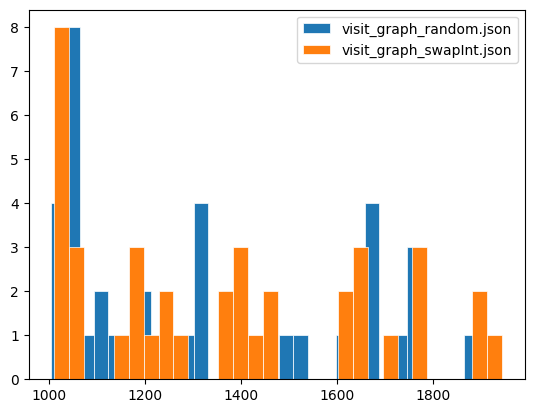

In [62]:
graph_random = read_data("/RSE/RLDS/work/fuzzing_data/raft/round_robin_10k/visit_graph_random.json")
graph_swapint = read_data("/RSE/RLDS/work/fuzzing_data/raft/round_robin_10k/visit_graph_swapInt.json")
compare_visit_hists([graph_random, graph_swapint], between_visits(1000, 2000))